In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

### Load the Data and Make Transformations

In [2]:
#Sales per StoreType
s_type='a'
#load data
train=pd.read_csv("../data/train.csv",low_memory=False)
store=pd.read_csv("../data/store.csv",low_memory=False)
#clean
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
train_store=pd.merge(train,store,how='inner',on='Store')
train_store.fillna(0,inplace=True)
data = train_store[train_store['StoreType']==s_type].loc[:,['Date','Sales']]
scaler = MinMaxScaler()
data.head()

,Date,Sales
942,2015-07-31,6064
943,2015-07-30,5567
944,2015-07-29,6402
945,2015-07-28,5671
946,2015-07-27,6627


In [3]:
df=data.groupby('Date')['Sales'].sum()
df=df.to_frame()
df.head()

,Sales
Date,
2013-01-01,2907
2013-01-02,3920386
2013-01-03,3528027
2013-01-04,3610215
2013-01-05,2964587


In [4]:
df.describe()

,Sales
count,9.420000e+02
mean,3.360228e+06
std,1.741426e+06
min,0.000000e+00
25%,2.994007e+06
50%,3.563650e+06
75%,4.459142e+06
max,8.511488e+06


In [5]:
#drop rows where Sales==0
df = df.loc[~(df['Sales'] == 0)]

In [6]:
scaler.fit(df.Sales.values.reshape([-1, 1]))
df_scaled = scaler.transform(df.Sales.values.reshape(-1, 1))
df['SalesScaled'] = df_scaled
df.tail(10)

,Sales,SalesScaled
Date,,
2015-07-22,3337937,0.392120
2015-07-23,3594960,0.422319
2015-07-24,3499777,0.411136
2015-07-25,2847063,0.334443
2015-07-26,55506,0.006442
2015-07-27,5603824,0.658356
2015-07-28,4910264,0.576865
2015-07-29,4524391,0.531525
2015-07-30,4685380,0.550441


### Descriptive Statistics and Visualizations of the Data.

In [7]:
df.describe()

,Sales,SalesScaled
count,9.160000e+02,916.000000
mean,3.455606e+06,0.405946
std,1.669966e+06,0.196217
min,6.800000e+02,0.000000
25%,3.037683e+06,0.356841
50%,3.597093e+06,0.422570
75%,4.482220e+06,0.526570
max,8.511488e+06,1.000000


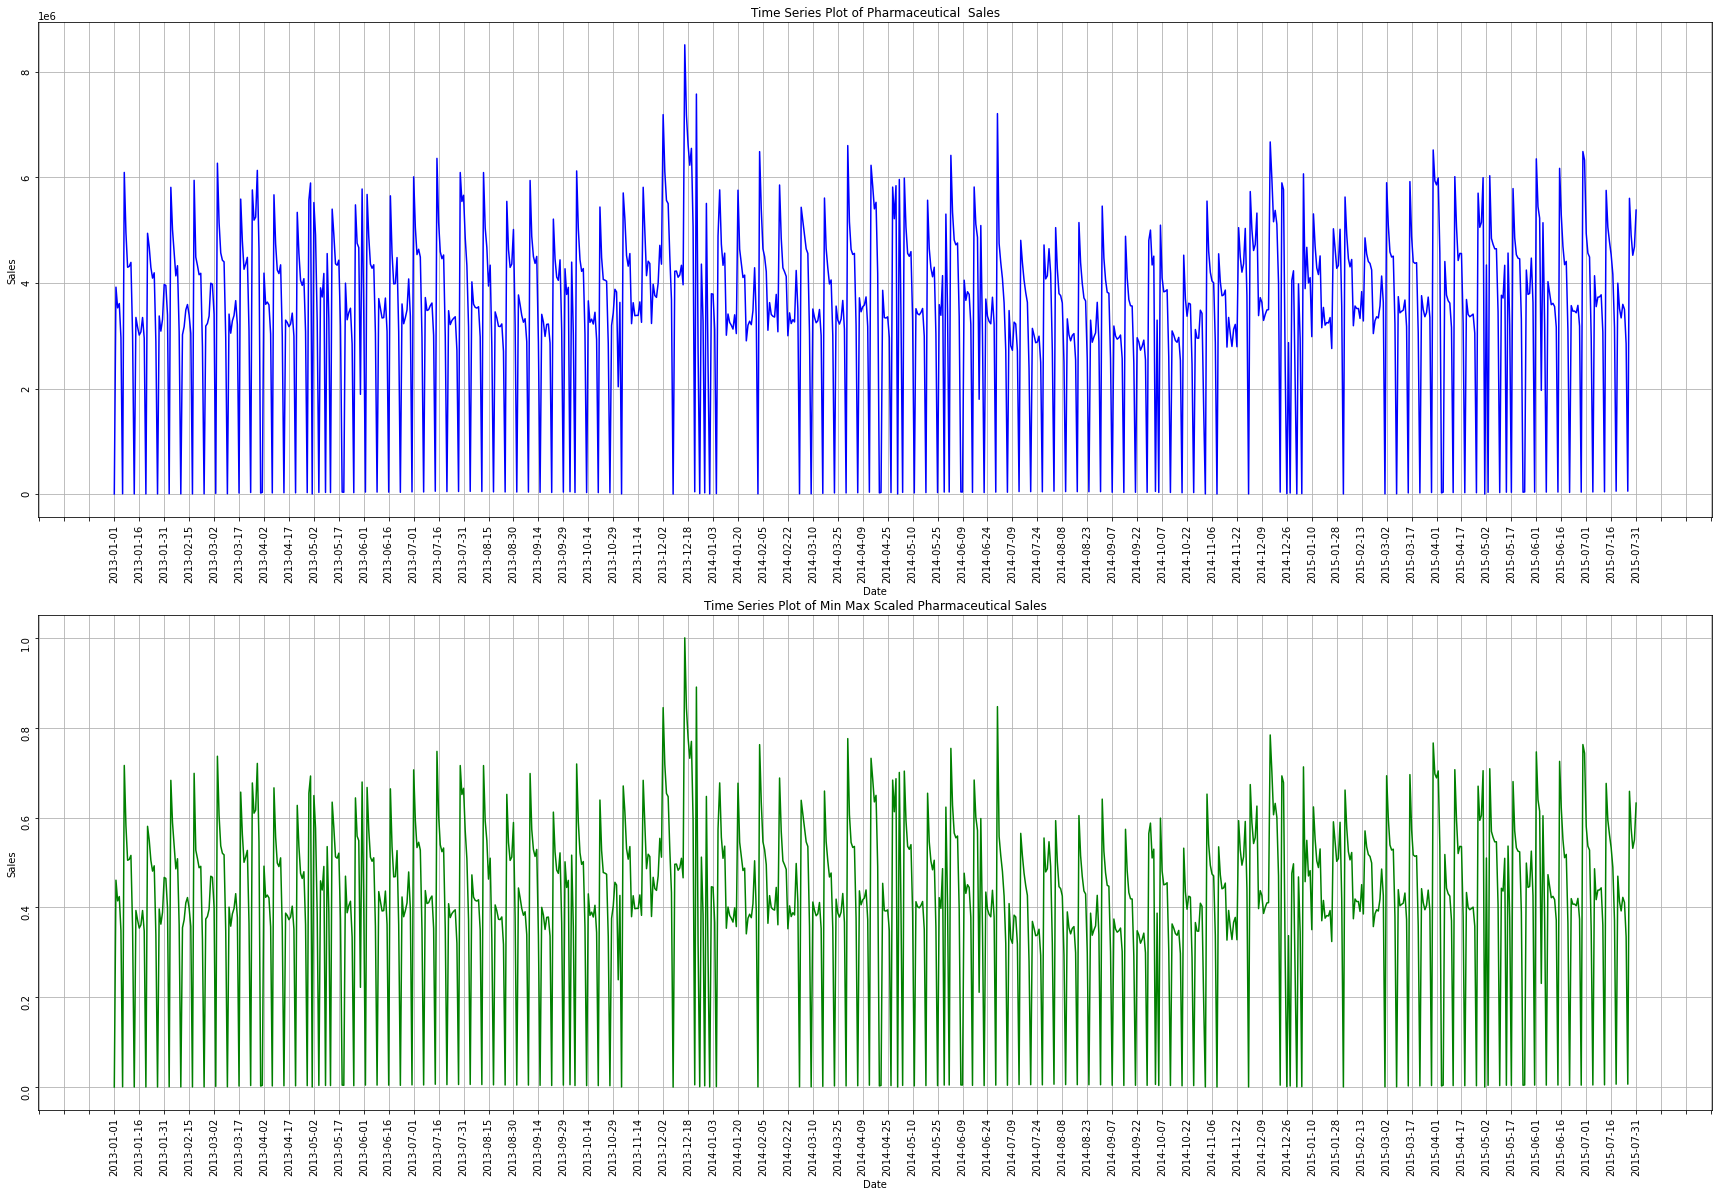

In [8]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(df.index, df.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales')
ax1.title.set_text('Time Series Plot of Pharmaceutical  Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(df.index, df.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Sales')
ax2.title.set_text('Time Series Plot of Min Max Scaled Pharmaceutical Sales')
ax2.grid(True)
plt.show()

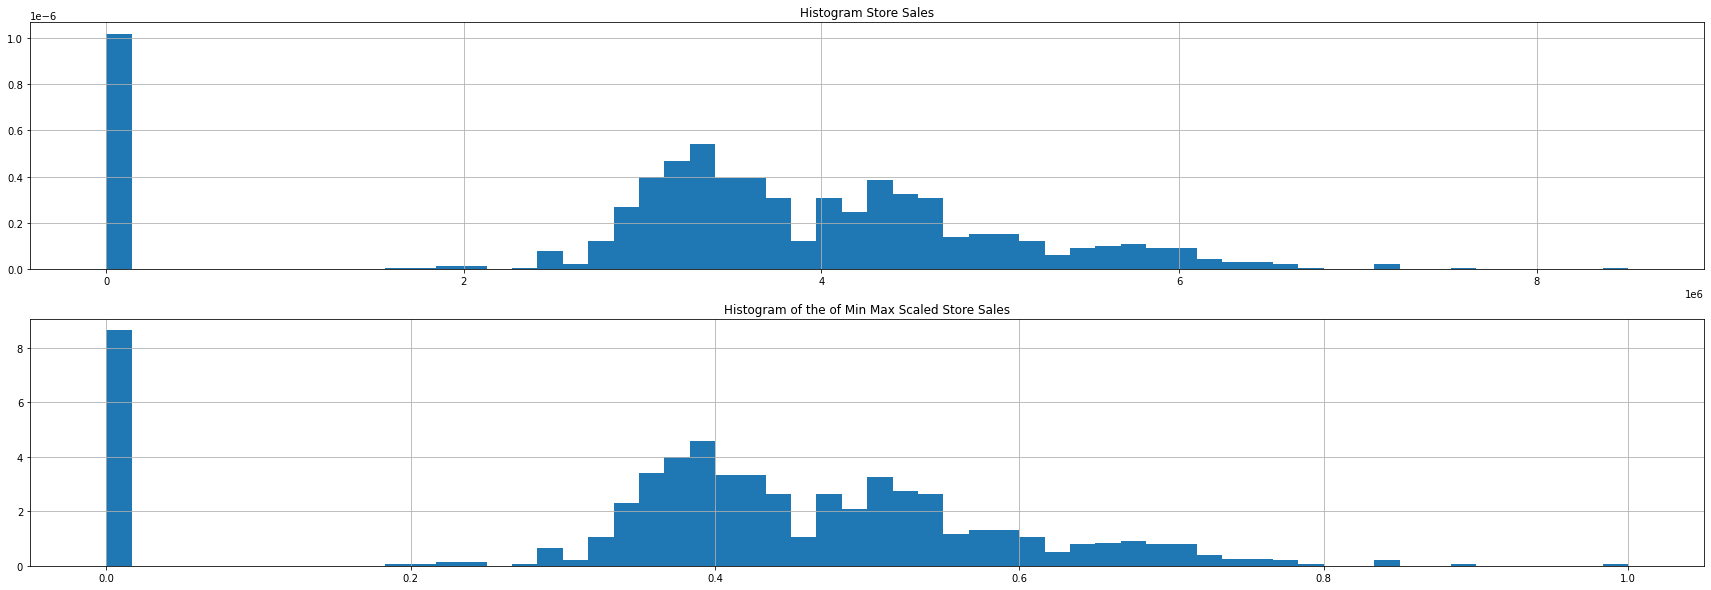

In [9]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(df.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(df.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Store Sales')
ax2.grid(True)
plt.show()

### Unit Root Tests.

Unit Root Tests helps us determine the stationarity of our data

In [10]:
adfResult = adfuller(df.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -4.417327515595938
p-value: 0.0002765603903414674


In [11]:
adfResult = adfuller(df.SalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -4.417327515595912
p-value: 0.0002765603903414969


#### Removing Stationarity

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

In [12]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [13]:
SalesDif = difference(df.SalesScaled.values)

In [14]:
SalesDif

0      0.460295
1     -0.046101
2      0.009657
3     -0.075860
4     -0.347597
         ...   
910    0.651914
911   -0.081492
912   -0.045339
913    0.018916
914    0.081658
Length: 915, dtype: float64

### Autocorrelations and Partial Autocorrelations Plots.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

In [15]:
acfSalesScaled = acf(df.SalesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [16]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of House Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

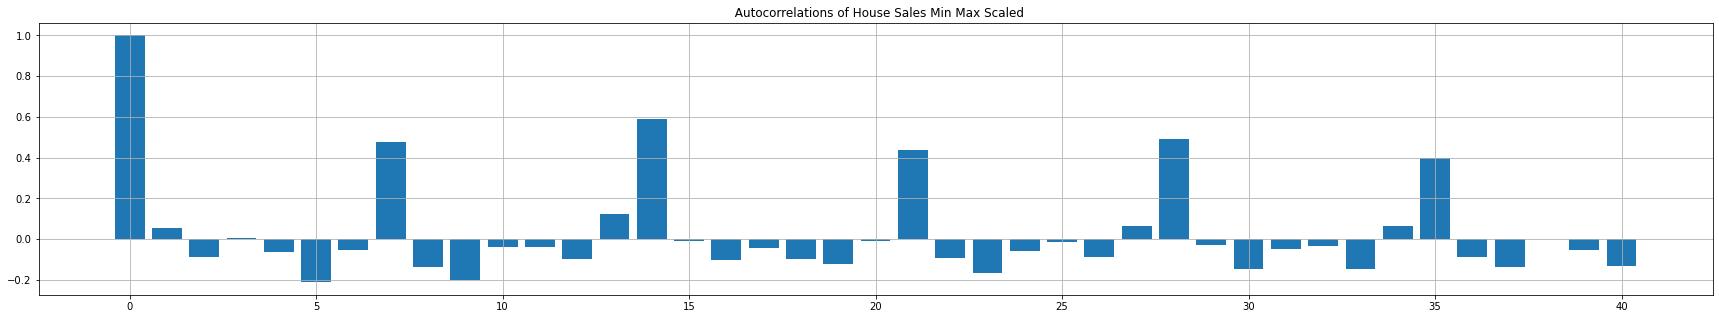

In [17]:
corrPlots(acfSalesScaledNp, '')

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed

In [18]:
pacfSalesScaled = pacf(df.SalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

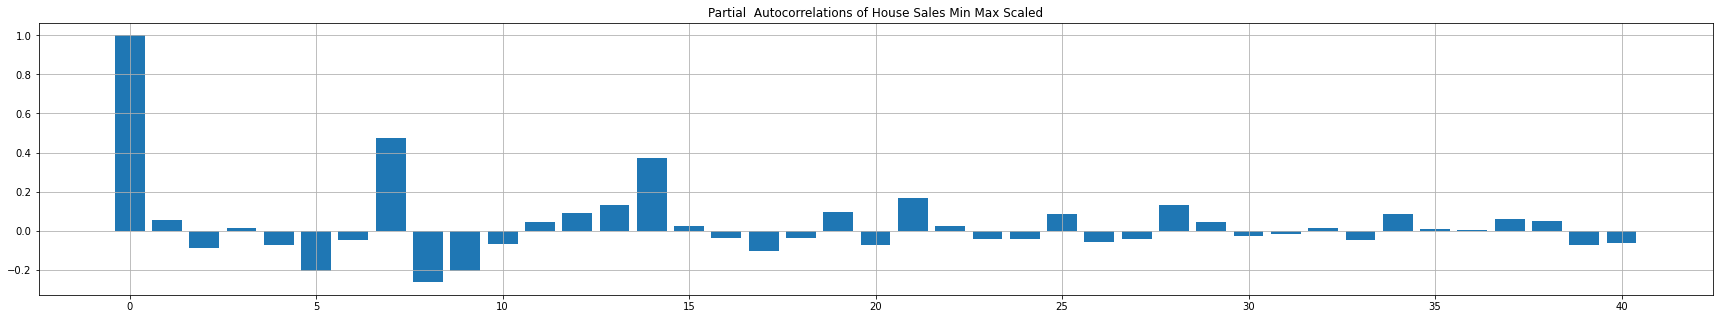

In [19]:
corrPlots(pacfSalesScaledNp, "Partial")

### Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [20]:
SIZE = len(df.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [21]:
DateTrain = df.index.values[0:BATCH_SIZE]
DateValid = df.index.values[BATCH_SIZE:]
XTrain = df.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = df.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (820, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (820,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [22]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([820, 1])

In [23]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset shapes: (1,), types: tf.float32>

In [24]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [25]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [26]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

The window() method returns a dataset containing windows, where each window is itself represented as a dataset. Something like {{1,2,3,4,5},{6,7,8,9,10},...}, where {...} represents a dataset. But we just want a regular dataset containing tensors: {[1,2,3,4,5],[6,7,8,9,10],...}, where [...] represents a tensor. The flat_map() method returns all the tensors in a nested dataset, after transforming each nested dataset. If we didn't batch, we would get: {1,2,3,4,5,6,7,8,9,10,...}. By batching each window to its full size, we get {[1,2,3,4,5],[6,7,8,9,10],...}

In [27]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [28]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [29]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [30]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

### Define and Estimate the LSTM.

In [31]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

The Huber loss is chosen because it is quite robust for non linear regression models and models with non normal errors.

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 8)           320       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 15s 15s/step - loss: 0.1607 - val_loss: 0.1684
Epoch 2/200
1/1 [==============================] - 1s 524ms/step - loss: 0.1553 - val_loss: 0.1630
Epoch 3/200
1/1 [==============================] - 1s 542ms/step - loss: 0.1502 - val_loss: 0.1577
Epoch 4/200
1/1 [==============================] - 1s 547ms/step - loss: 0.1452 - val_loss: 0.1526
Epoch 5/200
1/1 [==============================] - 1s 516ms/step - loss: 0.1403 - val_loss: 0.1477
Epoch 6/200
1/1 [==============================] - 1s 536ms/step - loss: 0.1357 - val_loss: 0.1430
Epoch 7/200
1/1 [==============================] - 1s 536ms/step - loss: 0.1312 - val_loss: 0.1384
Epoch 8/200
1/1 [==============================] - 1s 544ms/step - loss: 0.1268 - val_loss: 0.1339
Epoch 9/200
1/1 [==============================] - 1s 541ms/step - loss: 0.1226 - val_loss: 0.1296
Epoch 10/200
1/1 [==============================] - 1s 541ms/step - loss: 0.1185 - val_loss: 0.1254
Epoch 11/2

1/1 [==============================] - 1s 536ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 84/200
1/1 [==============================] - 1s 534ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 85/200
1/1 [==============================] - 1s 542ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 86/200
1/1 [==============================] - 1s 534ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 87/200
1/1 [==============================] - 1s 546ms/step - loss: 0.0187 - val_loss: 0.0204
Epoch 88/200
1/1 [==============================] - 1s 551ms/step - loss: 0.0187 - val_loss: 0.0204
Epoch 89/200
1/1 [==============================] - 1s 543ms/step - loss: 0.0187 - val_loss: 0.0204
Epoch 90/200
1/1 [==============================] - 1s 541ms/step - loss: 0.0187 - val_loss: 0.0205
Epoch 91/200
1/1 [==============================] - 1s 536ms/step - loss: 0.0187 - val_loss: 0.0205
Epoch 92/200
1/1 [==============================] - 1s 541ms/step - loss: 0.0187 - val_loss: 0.0205
Epoch 93/200


1/1 [==============================] - 0s 482ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 165/200
1/1 [==============================] - 0s 495ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 166/200
1/1 [==============================] - 1s 504ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 167/200
1/1 [==============================] - 1s 561ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 168/200
1/1 [==============================] - 1s 530ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 169/200
1/1 [==============================] - 1s 549ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 170/200
1/1 [==============================] - 1s 535ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 171/200
1/1 [==============================] - 1s 555ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 172/200
1/1 [==============================] - 1s 568ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 173/200
1/1 [==============================] - 1s 554ms/step - loss: 0.0187 - val_loss: 0.0203
Epoc

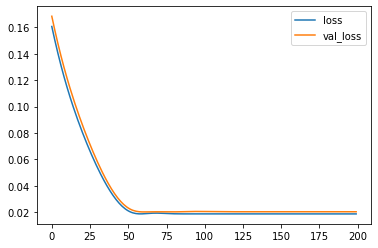

In [34]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

### Forecast the LSTM on the Validation Set and Assess Accuracy.

In [35]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [36]:
Forecast = model_forecast(model, df.SalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

A state is: Where am I now inside a sequence? Which time step is it? How is this particular sequence behaving since its beginning up to now?

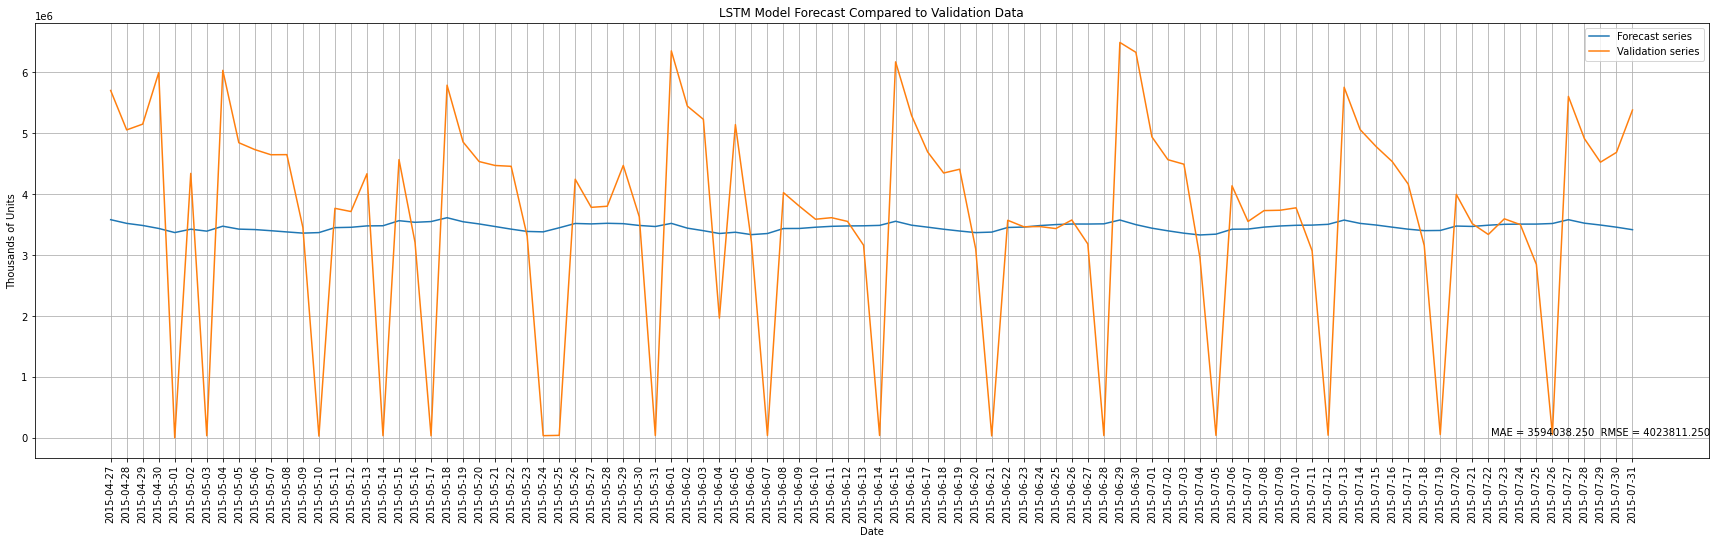

In [37]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [38]:
print(textstr)

MAE = 3594038.250  RMSE = 4023811.250
